In [5]:
!pip install transformers datasets accelerate torch sentencepiece
!nvidia-smi  # Verify T4 GPU is available

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.6.0-cp313-cp313-win_amd64.whl.metadata (28 kB)
  Using cached sentencepiece-0.2.0.tar.gz (2.6 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
          exec(compile('''
          ~~~~^^^^^^^^^^^^
          # This is <pip-setuptools-caller> -- a caller that pip uses to run setup.py
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          ...<31 lines>...
          exec(compile(setup_py_code, filename, "exec"))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          ''' % ('C:\\Users\\Admin\\AppData\\Local\\Temp\\pip-install-we4vw_n2\\sentencepiece_c8500ba2ccc9494084caff1f2d507620\\setup.py',), "<pip-setuptools-caller>", "exec"))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "<pip-setuptools-caller>", line 34, in <

In [5]:
!pip install torch transformers datasets

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached torch-2.6.0-cp313-cp313-win_amd64.whl.metadata (28 kB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.8/204.1 MB 3.7 MB/s eta 0:00:55
   ---------------------------------------- 1.6/204.1 MB 3.8 MB/s eta 0:00:54
   ---------------------------------------- 2.4/204.1 MB 3.7 MB/s eta 0:00:55
    --------------------------------------- 2.9/204.1 MB 3.5 MB/s eta 0:00:57
    --------------------------------------- 3.7/204.1 MB 3.7 MB/s eta 0:00:55
    --------------------------------------- 4.5/204.1 MB 3.7 MB/s eta 0:00:55
   - -------------------------------------- 5.2/204.1 MB 3.6 MB/s eta 0:00:55
   - -------------------------------------- 6.0/204.1 MB 3.6 MB/s eta 0:00:55
   - -------------------------------------- 6.8/204.1 MB 3.6 MB/s eta 0:00:55
   - -------------------------------------- 7.6/204.1 MB 3.6 MB/s eta 0:00:55
   - -------------------------------------- 8.4/204.1 MB 3.6 MB/s eta 0:00:54


In [3]:
import json
from datasets import Dataset
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch  # This import was missing in your original code

# Load your JSON data
with open("gpt_ready_data.json", "r") as f:
    data = json.load(f)

# Initialize tokenizer with legal tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

# Add special tokens and set padding
special_tokens = data["metadata"]["tokenizer_special_tokens"]
tokenizer.add_special_tokens({
    "additional_special_tokens": special_tokens,
    "pad_token": "[PAD]"  # Or use: tokenizer.pad_token = tokenizer.eos_token
})

# Tokenization function (modified to handle Colab's memory)
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,  # Reduced from 1024 for Colab memory
        padding="max_length",
        return_tensors="pt" if torch.cuda.is_available() else None
    )

# Convert to Dataset and tokenize
dataset = Dataset.from_list(data["data"])
try:
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        batch_size=4,  # Small batches for Colab
        remove_columns=["filename", "chunk_id", "token_count"]
    )
    print("Tokenization successful!")
    print(f"First sample keys: {tokenized_dataset[0].keys()}")
except Exception as e:
    print(f"Error during tokenization: {str(e)}")

Map: 100%|██████████| 193/193 [00:00<00:00, 534.61 examples/s]

Tokenization successful!
First sample keys: dict_keys(['text', 'input_ids', 'attention_mask'])


Text(0.5, 1.0, 'Token Length Distribution')

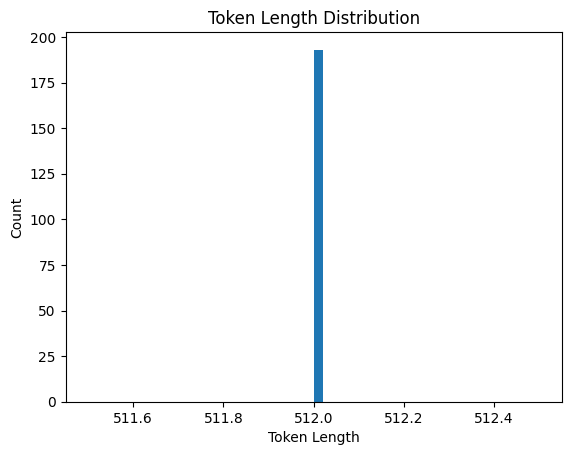

In [4]:
import matplotlib.pyplot as plt

# Analyze token lengths
token_lengths = [len(x['input_ids']) for x in tokenized_dataset]
plt.hist(token_lengths, bins=50)
plt.xlabel("Token Length")
plt.ylabel("Count")
plt.title("Token Length Distribution")

In [5]:
def add_labels(example):
    example['labels'] = example['input_ids'].copy()
    return example

tokenized_dataset = tokenized_dataset.map(add_labels, batched=True)

Map: 100%|██████████| 193/193 [00:00<00:00, 1312.39 examples/s]


In [6]:
split_dataset = tokenized_dataset.train_test_split(
    test_size=0.1,  # 10% for validation
    shuffle=True,
    seed=42
)

In [7]:
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
split_dataset = split_dataset.map(lambda x: x, batched=True)  # Apply format to both splits

Map: 100%|██████████| 20/20 [00:00<00:00, 3519.30 examples/s]


In [8]:
print("Train sample keys:", split_dataset["train"][0].keys())
print("Sample input:\n", tokenizer.decode(split_dataset["train"][0]["input_ids"][:50]))

Train sample keys: dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])
Sample input:
  RIGHTS 1 2 SEC. 101. RIGHT OF ACCESS. 3 (a) IN GENERAL.—A covered entity shall make avail- 4 able a reasonable mechanism by which an individual may 5 access— 6 (1) the categories of personal information


In [9]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained("gpt2-medium")  # 355M params (Colab-friendly)
model.resize_token_embeddings(len(tokenizer))  # For added legal tokens

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50263, 1024)

In [10]:
model.gradient_checkpointing_enable()  # Reduces VRAM usage by ~60%
model.config.use_cache = False  # Required for gradient checkpointing

In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./legal-gpt",
    per_device_train_batch_size=2,    # Fits Colab T4 GPU
    gradient_accumulation_steps=8,    # Effective batch size=16
    num_train_epochs=3,
    learning_rate=5e-5,
    warmup_steps=500,
    fp16=True,                        # Enable mixed-precision
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=1000,
    optim="adafactor",                # Memory-efficient optimizer
    report_to="none"                  # Disable WandB logging
)

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal language modeling
    pad_to_multiple_of=8  # Optimizes GPU memory
)

In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    data_collator=data_collator,
)